<h1>STA 220 Assignment 4</h1>

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import requests
import time
import json
from cachecontrol import CacheControl
import json
from datetime import timedelta
from ratelimit import limits, sleep_and_retry
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange, NumeralTickFormatter, LabelSet
from bokeh.models import CustomJSTickFormatter, FixedTicker
from bokeh.models.widgets import Slider
from bokeh.layouts import layout
from bokeh.io import curdoc
import pandas as pd
from IPython.display import display
from ipywidgets import interact
from bokeh.io import export_png
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

driver = webdriver.Chrome()
driver.get("http://www.python.org")
assert "Python" in driver.title

I have used Microsoft Copilot to make my code cleaner and to add documentation

(a) Using devtools, find a way to retrieve the names of all listed world entities. In order to navigate to their respective site, I assembled the path by processing the country names. To this end, (i) write a function process_names that processes the name as string according to the requests query parameter.

In [2]:
base_url = "https://www.cia.gov/the-world-factbook/"

In [3]:
def process_names(name):
    """Process a name string to a standardized format.
    
    This function performs the following operations:
    - Removes parentheses and their content
    - Replaces spaces and commas with hyphens
    - Replaces consecutive hyphens with a single hyphen
    - Removes trailing hyphens
    - Converts to lowercase
    
    Args:
        name (str): The name string to process.
        
    Returns:
        str: The processed name string.
    """
    name = name.replace('(','').replace(')','')
    name = name.replace("'", '')
    name = name.replace(' ', '-').replace(',', '')
    name = re.sub(r'-+', '-', name)
    name = name.rstrip('-')
    name = name.lower()
    return name

In [4]:
process_names('Falkland Islands (Islas Malvinas)')

'falkland-islands-islas-malvinas'

In [5]:
print(process_names('French Southern and Antarctic Lands'))
print(process_names('Bahamas, The'))

french-southern-and-antarctic-lands
bahamas-the


(ii) Obtain all world entity names. How many have you found? Hint: I could not retrieve data for all 266 entities that the CIA WFB claims to have.

In [6]:
def create_session():
    """Creates a cached session for making requests."""
    session = requests.Session()
    return CacheControl(session)

def fetch_links(session, base_url):
    """Fetches links from the base URL.
    
    Args:
        session (requests.Session): The session to use for making requests.
        base_url (str): The base URL to fetch links from.
        
    Returns:
        list: The list of links.
    """
    response = session.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    divs = soup.find_all('div', {'class': 'content-card-teaser'})

    # Iterate over the divs and find the one that contains the h2 tag with the desired text
    for div in divs:
        h2 = div.find('h2')
        if h2 and h2.text == "The World & Its Regions":
            # Extract the links of all world entities
            links = [base_url + a['href'] for a in div.find_all('a') if 'world' not in a['href']]
            return links

session = create_session()
links = fetch_links(session, base_url)


In [7]:
def extract_country_names(url):
    """
    Extracts country names from the specified URL.

    Args:
        url (str): The URL containing the list of countries.

    Returns:
        list: A list of country names.
    """
    try:
        countries = []
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception if the request fails
        soup = BeautifulSoup(response.text, 'html.parser')
        div_tags = soup.find_all('div', class_='col-md-4 border-left-db5')
        for div in div_tags:
            list_items = div.find_all('li')
            countries.extend([item.text.strip() for item in list_items]) 
        return countries
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return []

In [8]:
def collect_country_names(urls):
    """
    Collects country names from a list of URLs.

    Args:
        urls (list): The list of URLs to extract country names from.

    Returns:
        list: A list of all country names collected.
    """
    all_country_names = []  # Initialize an empty list to store all country names

    for url in urls:
        country_names = extract_country_names(url)
        all_country_names.extend(country_names)  # Extend the list with country names from each URL
        print(f"URL: {url} | Number of countries: {len(country_names)}")
        print(country_names)

    return all_country_names

all_country_names = collect_country_names(links)
print(f"Total number of countries collected: {len(all_country_names)}")


URL: https://www.cia.gov/the-world-factbook/africa/ | Number of countries: 55
['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Democratic Republic of the', 'Congo, Republic of the', "Cote d'Ivoire", 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Saint Helena, Ascension, and Tristan da Cunha', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']
URL: https://www.cia.gov/the-world-factbook/antarctica/ | Number of countries: 4
['Antarctica', 'Bouvet Island', 'French Southern and Antarctic Lands', 'Heard Island an

(iii) Write a function get_info takes a country name as string as input and return all the information as json that is displayed on its respective site. Use the retrieved data set for the next exercises. Hint: If you rate-limit your requests (you should!) this may take up to 10 minutes.

In [9]:
# List of special country names
special_countries = ["Baker Island", "Howland Island", "Jarvis Island", 
                     "Johnston Atoll", "Kingman Reef", "Midway Islands", 
                     "Palmyra Atoll"]

@sleep_and_retry
@limits(calls=26, period=timedelta(seconds=60).total_seconds())
def get_info(country_name):
    """
    Fetches information for a given country from the CIA World Factbook.

    Args:
        country_name (str): The name of the country.

    Returns:
        dict: A dictionary containing the country information.
    """
    processed_name = process_names(country_name)
    base_url = "https://www.cia.gov/the-world-factbook/page-data/countries/"
    
    # Check if the country name is in the list of special countries
    if country_name in special_countries:
        url = f"{base_url}united-states-pacific-island-wildlife-refuges/page-data.json"
    else:
        url = f"{base_url}{processed_name}/page-data.json"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data
    except requests.RequestException as e:
        print(f"Error fetching data for {country_name}: {e}")
        return {}

all_country_info = {country_name: get_info(country_name) for country_name in all_country_names}


Some of the countries do not have a page-data.json corresponding to their names- Baker Island, Howland Island, Jarvis Island, Johnston Atoll, Kingman Reef, Midway Islands, Palmyra Atoll

(b) Lets learn about the newest updated data points in the CIA world factbook - the merchant marine! (i) Write a function ports that returns a list of all major seaports of a given country. Run:

ports('United States')

In [10]:
def remove_em_tags(data):
    """
    Removes <em> tags from the given data.

    Args:
        data (str): The data from which to remove <em> tags.

    Returns:
        str: The data with <em> tags removed.
    """
    pattern = r'<em>.*?</em>'
    return re.sub(pattern, '', data)


In [11]:
def remove_html_tags(data):
    """
    Removes HTML tags from the given data and replaces line breaks with commas.

    Args:
        data (str): The data from which to remove HTML tags.

    Returns:
        str: The data with HTML tags removed.
    """
    # Replace line breaks with commas
    replaced_data = re.sub(r'\s*<br />\s*', ', ', data)
    
    # Remove all other HTML tags
    no_html = re.sub(r'<.*?>', '', replaced_data)
    
    return no_html


In [12]:
def split_and_strip(data):
    """
    Splits the input data by commas and strips whitespace from each item.

    Args:
        data (str): The string to split and strip.

    Returns:
        list: A list of stripped items.
    """
    return [item.strip() for item in data.split(',')]


In [13]:
def ports(country_name):
    """
    Extracts major seaports information for a given country.

    Args:
        country_name (str): The name of the country.
        all_country_info (dict): A dictionary containing country information.

    Returns:
        list: A list of major seaports for the country.
    """
    country_info = all_country_info.get(country_name)
    
    # Return an empty list if there's no info for the country or 'result' key is missing
    if not country_info or 'result' not in country_info:
        return []

    data_list = country_info['result']['data']['fields']['nodes']
    ports_data = next((element["data"] for element in data_list if element["name"] == "Ports and terminals"), "")

    # Extract the major seaports
    seaports_match = re.search("<strong>major seaport\(s\):</strong>(.*?)<br><br>", ports_data, re.DOTALL)
    
    if seaports_match:
        seaports_data = remove_em_tags(seaports_match.group(1))
        seaports_string_data = remove_html_tags(seaports_data)
        return split_and_strip(seaports_string_data)
    
    return []


In [14]:
print(ports('United States'))

['Charleston', 'Hampton Roads', 'New York/New Jersey', 'Savannah', 'Long Beach', 'Los Angeles', 'Oakland', 'Seattle/Tacoma', 'Houston']


(ii) Lets put a marker on a world map corresponding to the location of all major seaports that you retrieved. Use the Nominatim API to get latitute-longitude pairs. Make structured queries and pass the city and country keys. Use the first value that is returned.

Print the world map. Name three markers that are apparently misplaced.

In [15]:
all_seaports_info = {}

for country_name in all_country_names:
    port_info = ports(country_name)
    if port_info:  # Check if port_info is not an empty list or None
        all_seaports_info[country_name] = port_info


In [16]:
def get_location(port, country_name):
    """
    Fetches the location of a port in a given country.

    Args:
        port (str): The name of the port.
        country_name (str): The name of the country.

    Returns:
        tuple: The latitude and longitude of the port.
    """
    url = f"https://nominatim.openstreetmap.org/search.php?city={port}&country={country_name}&format=jsonv2&addressdetails=1&limit=1"
    response = requests.get(url)
    data = response.json()
    if data:
        return float(data[0]["lat"]), float(data[0]["lon"])
    return None

def create_map(all_seaports_info):
    """
    Creates a map with markers for all seaports in the given info.

    Args:
        all_seaports_info (dict): A dictionary containing seaport info for each country.

    Returns:
        folium.Map: The created map.
    """
    # Create a map centered at an arbitrary location
    m = folium.Map(location=[0, 0], zoom_start=2)

    for country_name, ports in all_seaports_info.items():
        for port in ports:
            location = get_location(port, country_name)
            if location:
                # Add a marker to the map
                folium.Marker(location, popup=port).add_to(m)

    return m

m = create_map(all_seaports_info)
m

Three markers that are apparently misplaced, because on the map they appear to be landlocked but are actually supposed to be seaports so should be near water:
1. Belawan, Indonesia
2. Kandla, India
3. Vostochnyy, Russia

In [17]:
import io
from PIL import Image

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')


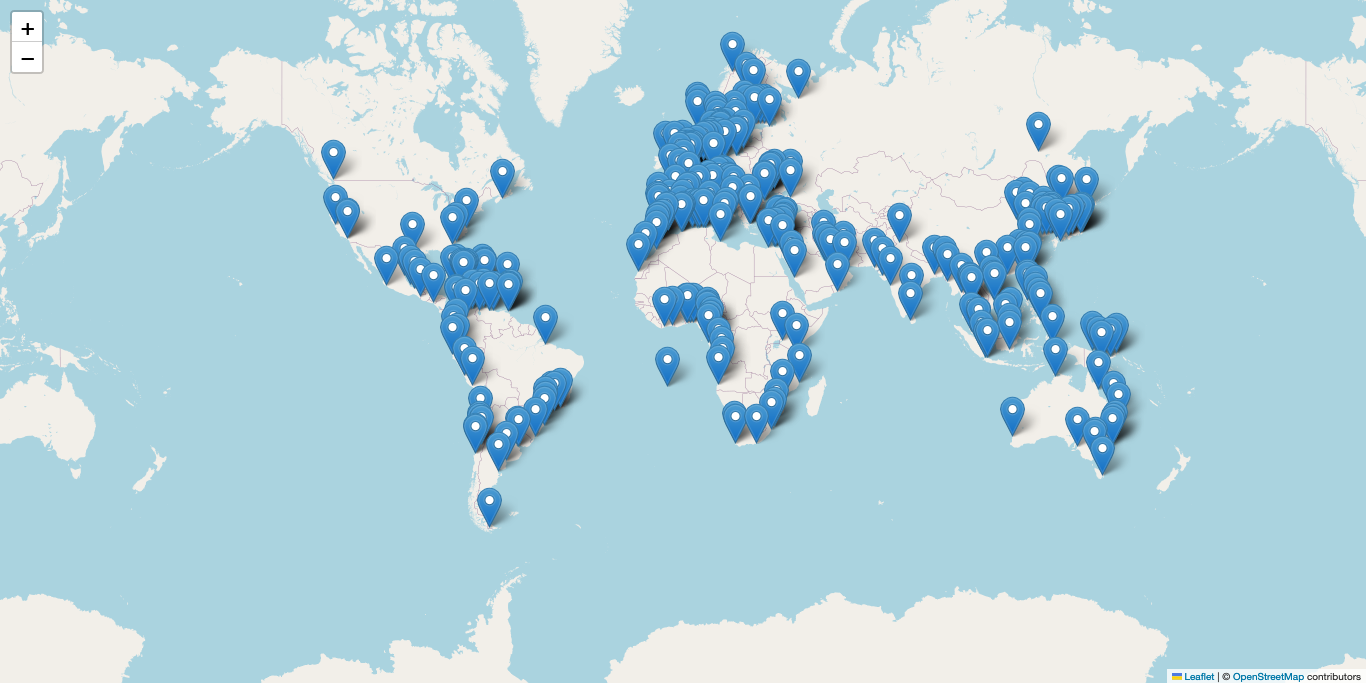

In [18]:
from IPython.display import Image
Image('image.png')

(iii) Amongst all countries with a major seaport, return the four that have the largest fleet of bulk carriers. Amongst all countries with no coastline, return the four that have the largest merchant marine fleet overall.

In [19]:
def bulk_carrier(country_name):
    """
    Extracts the number of bulk carriers for a given country.

    Args:
        country_name (str): The name of the country.
    
    Returns:
        int: The number of bulk carriers for the country.
    """
    country_info = all_country_info.get(country_name)
    
    # Return 0 if there's no info for the country or 'result' key is missing
    if not country_info or 'result' not in country_info:
        return 0

    data_list = country_info['result']['data']['fields']['nodes']
    merchant_data = next((element["data"] for element in data_list if element["name"] == "Merchant marine"), "")

    match = re.search(r'bulk carrier ([\d,]+)', merchant_data)
    if match:
        # Remove commas and convert to integer
        return int(match.group(1).replace(',', ''))
    
    return 0


In [20]:
bulk_carrier_dict = {}

for country_name in all_seaports_info:
    # Get the number of bulk carriers for the country
    bulk_carrier_num = bulk_carrier(country_name)
    
    # Add the country name and the number of bulk carriers to the dictionary
    bulk_carrier_dict[country_name] = bulk_carrier_num

In [21]:
def get_top_4_countries(dict_input):
    # Sort the dictionary by values in descending order and get the first 4 items
    top_4_countries = sorted(dict_input.items(), key=lambda x: x[1], reverse=True)[:4]
    return top_4_countries

In [22]:
top_4_countries = get_top_4_countries(bulk_carrier_dict)
print(f"Top 4 Countries with largest fleet of bulk carriers: {top_4_countries}")

Top 4 Countries with largest fleet of bulk carriers: [('Panama', 2732), ('China', 1831), ('Hong Kong', 1047), ('Singapore', 591)]


In [23]:
def get_country_info(country_name):
    """Fetches the country info from the global dictionary."""
    return all_country_info.get(country_name, {})

def get_data_list(country_info):
    """Extracts the data list from the country info."""
    return country_info.get('result', {}).get('data', {}).get('fields', {}).get('nodes', [])

def is_landlocked(data_list):
    """Checks if the country is landlocked."""
    for element in data_list:
        if element["name"] == "Coastline" and element["data"] == "0 km (landlocked)":
            return True
    return False

def get_merchant_marine_number(data_list):
    """Extracts the merchant marine number from the data list."""
    for element in data_list:
        if element["name"] == "Merchant marine":
            match = re.search(r'total:</strong> ([\d,]+)', element["data"])
            if match:
                # Remove commas and convert to integer
                return int(match.group(1).replace(',', ''))
    return 0

In [24]:
def no_coastline_merchant_marine(country_name):
    """
    Returns the number of merchant marines for a landlocked country.

    Args:
        country_name (str): The name of the country.

    Returns:
        int: The number of merchant marines if the country is landlocked, 0 otherwise.
    """
    country_info = get_country_info(country_name)
    data_list = get_data_list(country_info)
    
    # Return 0 if there's no data list or the country is not landlocked
    if not data_list or not is_landlocked(data_list):
        return 0

    return get_merchant_marine_number(data_list)


In [25]:
no_coastline_merchant_marine_fleet_dict = {}

for country_name in all_country_names:
    no_coastline_merchant_marine_fleet = no_coastline_merchant_marine(country_name)
    no_coastline_merchant_marine_fleet_dict[country_name] = no_coastline_merchant_marine_fleet

In [26]:
top_4_countries = get_top_4_countries(no_coastline_merchant_marine_fleet_dict)
print(f"Top 4 no coastline countries with largest fleet of merchant marine overall: {top_4_countries}")

Top 4 no coastline countries with largest fleet of merchant marine overall: [('Mongolia', 318), ('Luxembourg', 147), ('Paraguay', 108), ('Moldova', 75)]


(c) Now, lets classify whether a country is or has been controlled by the United Kingdom by analyzing the provided background information text. (i) Implement a (very simple!) classification method that performs this task. My function was_british correctly identifies the countries of Pakistan and Russia, but incorrectly classifies Spain and the United States.

How many world entities do you find to be current or former parts of the British Empire?

In [27]:
def was_british(country_name):
    """
    Checks if a country was a British colony based on its background information.

    Args:
        country_name (str): The name of the country.

    Returns:
        bool: True if the country was a British colony, False otherwise.
    """
    country_info = all_country_info.get(country_name)
    
    # Return False if there's no info for the country or 'result' key is missing
    if not country_info or 'result' not in country_info:
        return False

    data_list = country_info['result']['data']['fields']['nodes']
    background_data = next((element["data"] for element in data_list if element["name"] == "Background"), "")

    return "British" in background_data


In [28]:
print(was_british('Pakistan'))
print(was_british('Russia'))

True
False


In [29]:
print(was_british('Spain'))
print(was_british('United States'))

False
False


I used a simple classification that would search for the word "British" in the background text because if the country was under british control, it would most likely have the word British in it. But as seen below this misclassifies United States since the word used is Britain's American colonies. A more detailed NLP analysis of the countries has to be done to identify the nations that were under British control to classify with precision.

In [30]:
was_british_countries = [country_name for country_name in all_country_names if was_british(country_name)]
count = len(was_british_countries)

print(was_british_countries)
print(f"The total count of current or former parts of British Empire is {count}")


['Botswana', 'Cameroon', 'Egypt', 'Eritrea', 'Ghana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Niger', 'Nigeria', 'Saint Helena, Ascension, and Tristan da Cunha', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Zambia', 'Zimbabwe', 'Antarctica', 'Bouvet Island', 'Ashmore and Cartier Islands', 'Australia', 'Baker Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Fiji', 'French Polynesia', 'Howland Island', 'Jarvis Island', 'Johnston Atoll', 'Kingman Reef', 'Marshall Islands', 'Midway Islands', 'Nauru', 'New Caledonia', 'New Zealand', 'Niue', 'Norfolk Island', 'Palmyra Atoll', 'Pitcairn Islands', 'Samoa', 'Solomon Islands', 'Tokelau', 'Tonga', 'Tuvalu', 'United States Pacific Island Wildlife Refuges', 'Vanuatu', 'Wallis and Futuna', 'Anguilla', 'Antigua and Barbuda', 'Bahamas, The', 'Barbados', 'Belize', 'British Virgin Islands', 'Cayman Islands', 'Dominica', 'Jamaica', 'Montserrat', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent an

(ii) Retrieve the ISO codes from here and use them to color all countries on a world map that you have determined to be former parts of the British Empire. The map should look something like this.

In [31]:
def fetch_iso_codes(url):
    """
    Fetches ISO codes for countries from the given URL.

    Args:
        url (str): The URL to fetch ISO codes from.

    Returns:
        dict: A dictionary mapping country names to ISO codes.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find('table')
    rows = table.find_all('tr')

    iso_codes = {row.find_all('td')[0].text.strip(): row.find_all('td')[1].text.strip() for row in rows if row.find_all('td')}

    return iso_codes

url = "https://www.cia.gov/the-world-factbook/references/country-data-codes/"
iso_codes = fetch_iso_codes(url)


In [32]:
# Map the ISO codes to the countries, excluding those without an ISO code
was_british_iso_codes = {country: iso_codes[country] for country in was_british_countries if country in iso_codes}

print(was_british_iso_codes)

{'Botswana': 'BWA', 'Cameroon': 'CMR', 'Egypt': 'EGY', 'Eritrea': 'ERI', 'Ghana': 'GHA', 'Kenya': 'KEN', 'Lesotho': 'LSO', 'Malawi': 'MWI', 'Mauritius': 'MUS', 'Niger': 'NER', 'Nigeria': 'NGA', 'Saint Helena, Ascension, and Tristan da Cunha': 'SHN', 'Sierra Leone': 'SLE', 'Somalia': 'SOM', 'South Africa': 'ZAF', 'South Sudan': 'SSD', 'Sudan': 'SDN', 'Tanzania': 'TZA', 'Uganda': 'UGA', 'Zambia': 'ZMB', 'Zimbabwe': 'ZWE', 'Antarctica': 'ATA', 'Bouvet Island': 'BVT', 'Ashmore and Cartier Islands': 'XAC', 'Australia': 'AUS', 'Baker Island': 'XBK', 'Cocos (Keeling) Islands': 'CCK', 'Cook Islands': 'COK', 'Fiji': 'FJI', 'French Polynesia': 'PYF', 'Howland Island': 'XHO', 'Jarvis Island': 'XJV', 'Johnston Atoll': 'XJA', 'Kingman Reef': 'XKR', 'Marshall Islands': 'MHL', 'Midway Islands': 'XMW', 'Nauru': 'NRU', 'New Caledonia': 'NCL', 'New Zealand': 'NZL', 'Niue': 'NIU', 'Norfolk Island': 'NFK', 'Palmyra Atoll': 'XPL', 'Pitcairn Islands': 'PCN', 'Samoa': 'WSM', 'Solomon Islands': 'SLB', 'Tokela

/var/folders/fs/sxz9py7d769g8_sqsj_m1sbh0000gn/T/ipykernel_16662/1237421414.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/fs/sxz9py7d769g8_sqsj_m1sbh0000gn/T/ipykernel_16662/1237421414.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(british_countries.geometry.centroid.x, british_countries.geometry.centroid.y, british_countries.name):
/var/folders/fs/sxz9py7d769g8_sqsj_m1sbh0000gn/T/ipykernel_16662/1237421414.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a pr

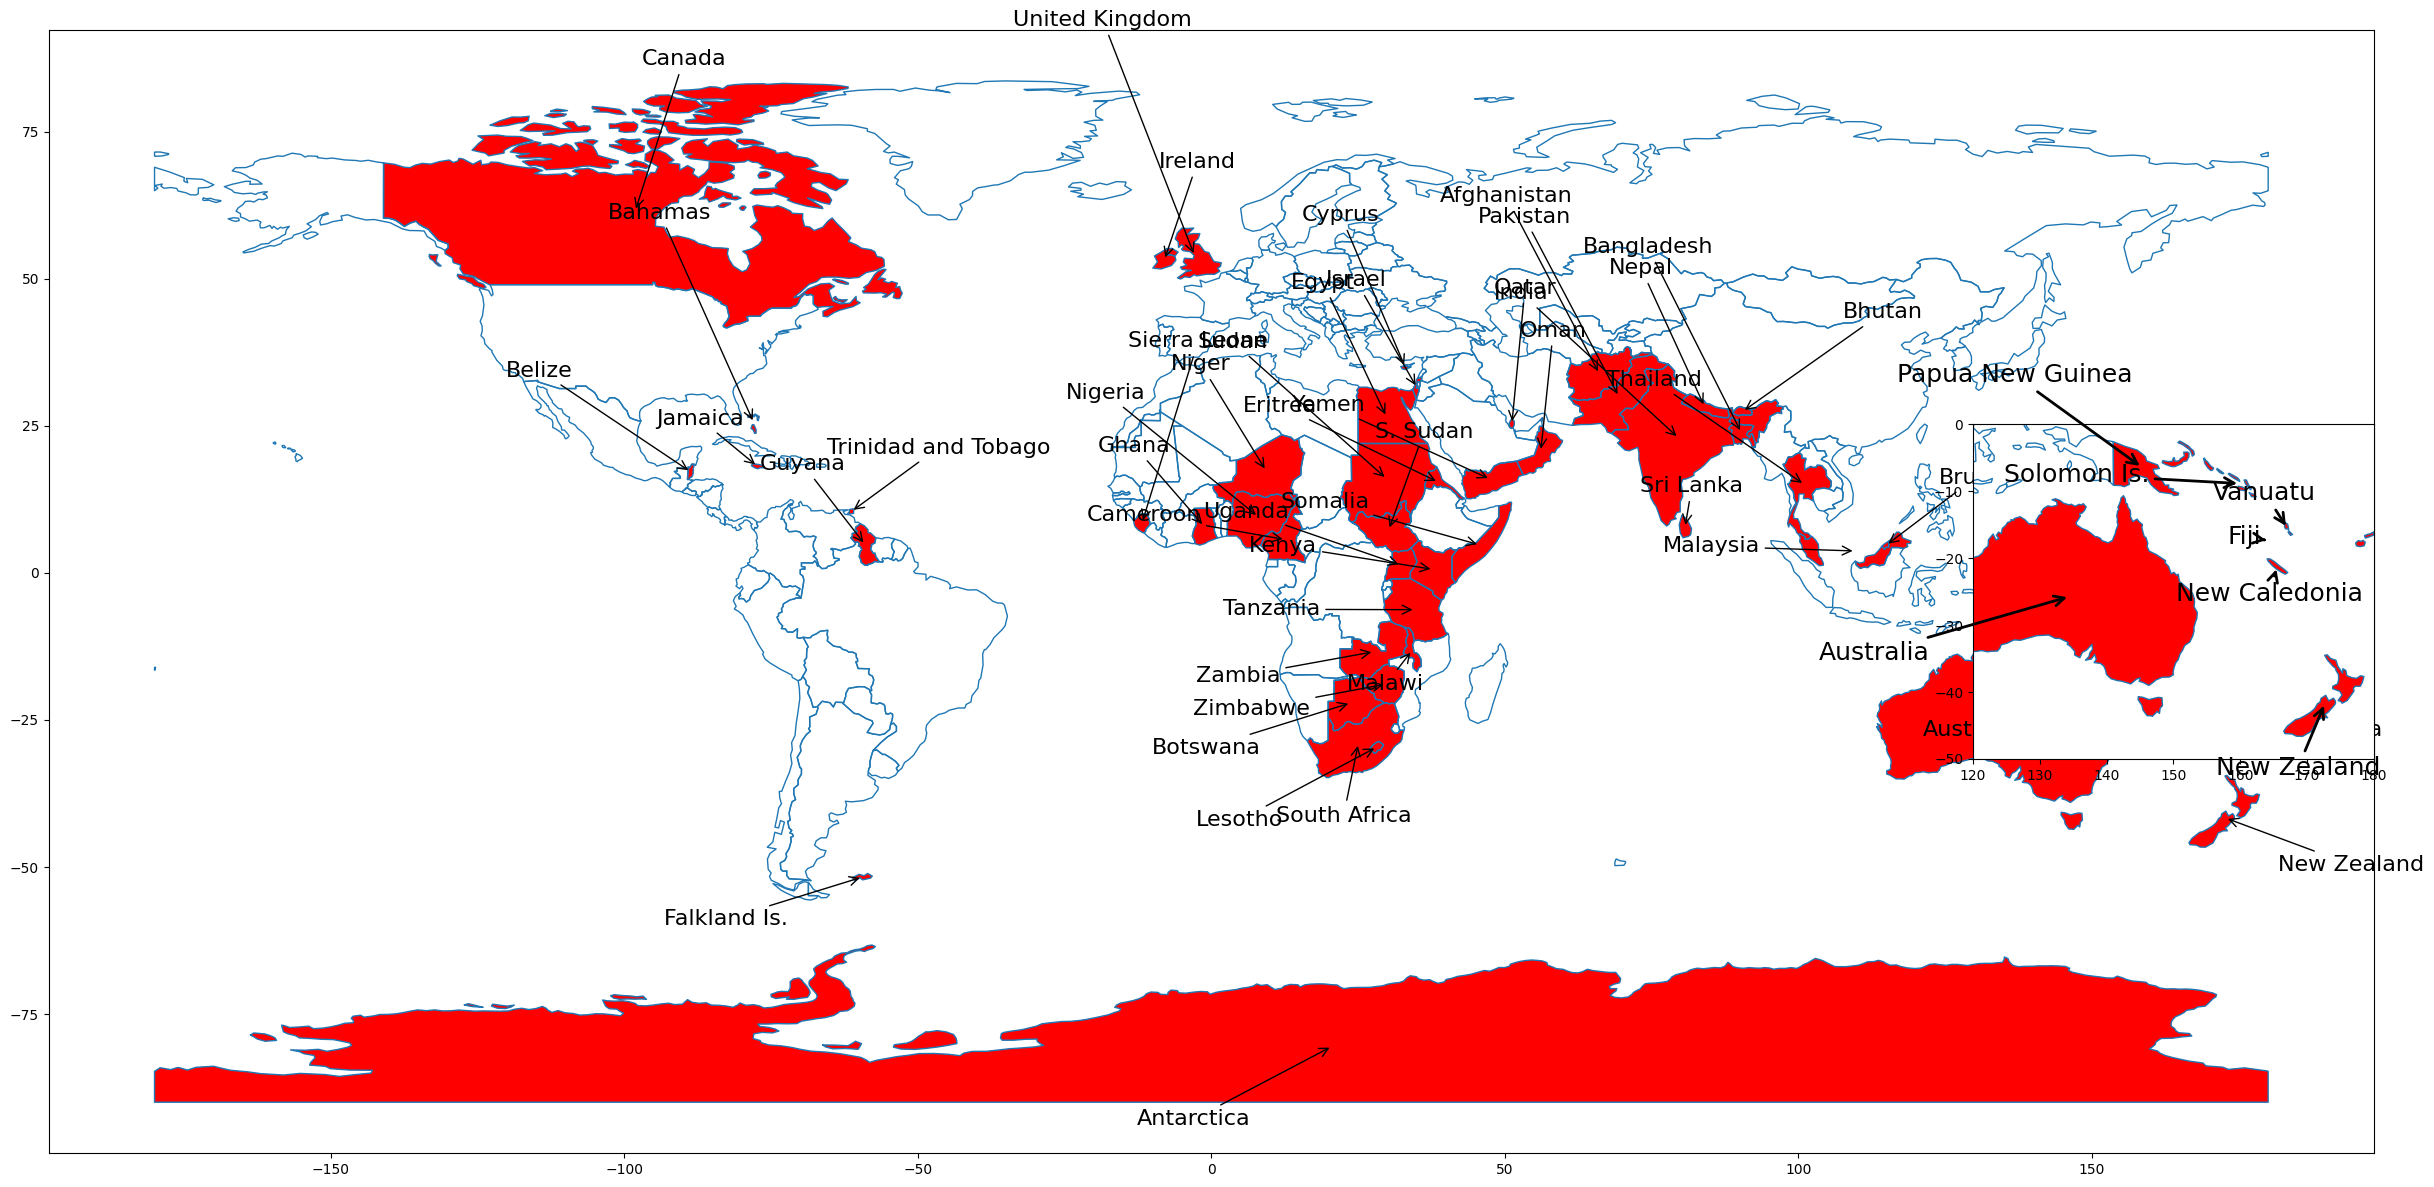

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from adjustText import adjust_text

def plot_british_countries(was_british_iso_codes):
    # Load the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Mark the countries that were part of the British Empire
    world['was_british'] = world['iso_a3'].isin(was_british_iso_codes.values())

    # Create a GeoDataFrame with only the British countries
    british_countries = world[world['was_british']]

    # Create the figure and the main subplot
    fig = plt.figure(figsize=(30, 30))  
    gs = gridspec.GridSpec(1, 5)  
    ax = fig.add_subplot(gs[0, :5])  
    world.boundary.plot(ax=ax, linewidth=1)
    british_countries.plot(ax=ax, color='red')

    # Create a zoomed-in subplot
    axins = fig.add_subplot(gs[0, 4])  
    british_countries.plot(ax=axins, color='red')
    world.boundary.plot(ax=axins, linewidth=1)

    # Specify the limits of your zoomed-in plot
    x1, x2, y1, y2 = 120, 180, -50, 0  
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    # Annotate the country names in the main plot
    texts = []
    for x, y, label in zip(british_countries.geometry.centroid.x, british_countries.geometry.centroid.y, british_countries.name):
        texts.append(ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=16,arrowprops=dict(arrowstyle="->", lw=1)))

    adjust_text(texts)

    # Annotate the country names in the zoomed-in subplot
    texts_ins = []
    for x, y, label in zip(british_countries.geometry.centroid.x, british_countries.geometry.centroid.y, british_countries.name):
        if x1 < x < x2 and y1 < y < y2:  # only annotate the countries within the limits of the zoomed-in plot
            texts_ins.append(axins.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=18, arrowprops=dict(arrowstyle="->", lw=2)))

    adjust_text(texts_ins)

    plt.show()

plot_british_countries(was_british_iso_codes)


(d) Lets build our own population pyramide (with only three steps) according to the obtained data (0-14, 15-64, 65+). Given the current health expenditure as threshold, we want to obtain create a population pyramide for all aggregated population values. (i) Assemble a data frame that given a threshold shows the aggregated population values of all data points which current health expenditure does not exceed the threshold, separated by gender. The first four rows of data frame df are given below.

How many distinct thresholds do you find?

In [34]:
def fetch_threshold(country_name):
    """
    Fetches the current health expenditure for a given country.

    Args:
        country_name (str): The name of the country.
        
    Returns:
        float: The current health expenditure for the country, or None if the data is not available.
    """
    country_info = all_country_info.get(country_name)
    
    # Return None if there's no info for the country or 'result' key is missing
    if not country_info or 'result' not in country_info:
        return None

    data_list = country_info['result']['data']['fields']['nodes']
    expenditure_data = next((element["data"] for element in data_list if element["name"] == "Current health expenditure"), "")

    # Check if the expenditure data is a number
    if expenditure_data and expenditure_data.split('%')[0].replace('.', '', 1).isdigit():
        return float(expenditure_data.split('%')[0])
    
    return None
    

In [35]:
# Fetch threshold values for all countries
threshold_values = {country_name: fetch_threshold(country_name) for country_name in all_country_info}

# Remove entries where threshold value is None
population_agg_dict = {country: threshold for country, threshold in threshold_values.items() if threshold is not None}

#store unique values in a set
threshold_values = set(population_agg_dict.values())

# Print the number of unique threshold values
print(f"Number of unique threshold values: {len(threshold_values)}")


Number of unique threshold values: 92


In [36]:
def fetch_age_structure(country_name):
    """
    Fetches the age structure data for a given country.

    Parameters:
    country_name (str): The name of the country for which to fetch the age structure data.

    Returns:
    str: The age structure data for the country. If the data is not available, returns an empty string.
    """
    # Get the country info from the dictionary, return an empty dictionary if the country is not found
    country_info = all_country_info.get(country_name, {})
    # Navigate through the nested dictionaries to get the list of nodes, return an empty list if any key is not found
    data_list = country_info.get('result', {}).get('data', {}).get('fields', {}).get('nodes', [])
    # Find the element in the list where the name is "Age structure", return an empty string if not found
    age_data = next((element["data"] for element in data_list if element["name"] == "Age structure"), "")
    return age_data


In [37]:
def get_figures(age_expression, age_structure):
    """
    Extracts the male and female population figures for a given age group from the age structure data.

    Parameters:
    age_expression (str): A regular expression that matches the age group in the age structure data.
    age_structure (str): The age structure data.

    Returns:
    dict: A dictionary with the male and female population figures for the age group. If the data is not available, returns None.
    """
    # Search for the age group in the data
    match = re.search(age_expression, age_structure)

    if match:
        data = match.group()
        # Extract the male and female figures
        male_match = re.search(r'male ([\d,]+)', data)
        female_match = re.search(r'female ([\d,]+)', data)

        if male_match and female_match:
            figures = {
                'male': int(male_match.group(1).replace(',', '')),
                'female': int(female_match.group(1).replace(',', ''))
            }
            return figures
        return None

#Usage
print(get_figures(r'0-14 years:</strong>.*?<br>', fetch_age_structure('United States')))
print(get_figures(r'15-64 years:</strong>.*?<br>', fetch_age_structure('United States')))
print(get_figures(r'<strong>65 years and over:</strong>(.*)', fetch_age_structure('United States')))

{'male': 31509186, 'female': 30154408}
{'male': 108346275, 'female': 108100830}
{'male': 27589149, 'female': 33965270}


In [38]:
# Initialize an empty list to store the data
data_list = []

# Iterate over all countries and fetch their threshold values
for country_name in all_country_info:
    threshold_value = fetch_threshold(country_name)
    if threshold_value is not None:  # Only add the value if it's not None
        age_structure = fetch_age_structure(country_name)
        if age_structure is not None:
            for age_group in [r'0-14 years:</strong>.*?<br>', r'15-64 years:</strong>.*?<br>', r'<strong>65 years and over:</strong>(.*)']:
                figures = get_figures( age_group , age_structure)
                if figures is not None:
                    # Append the data to the list
                    data_list.append([age_group, figures['male'], figures['female'], threshold_value])

# Create a DataFrame from the list
df = pd.DataFrame(data_list, columns=['Groups', 'Male', 'Female', 'Threshold'])


df['Groups'] = df['Groups'].replace({
    '0-14 years:</strong>.*?<br>': '0-14 years',
    '15-64 years:</strong>.*?<br>': '15-64 years',
    '<strong>65 years and over:</strong>(.*)': '65 years and over'
}, regex=True)


print(df)
            

                Groups      Male    Female  Threshold
0           0-14 years   6594512   6286191        6.3
1          15-64 years  14607255  14166990        6.3
2    65 years and over   1475635   1627815        6.3
3           0-14 years   8503242   8473889        2.9
4          15-64 years   8730015   9435581        2.9
..                 ...       ...       ...        ...
562        15-64 years  76548821  73065518        2.8
563  65 years and over   5482633   6337508        2.8
564         0-14 years   2609642   2511570        4.1
565        15-64 years   7609573   7836480        4.1
566  65 years and over   1156637   1602370        4.1

[567 rows x 4 columns]


In [39]:
# Get the unique thresholds
unique_thresholds = df['Threshold'].unique()

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Threshold', 'Group', 'Total Male', 'Total Female'])

# Iterate over the unique thresholds
for threshold in unique_thresholds:
    for group in df['Groups'].unique():
        # Get the rows where the threshold is greater than the current threshold and the group matches
        rows = df[(df['Threshold'] > threshold) & (df['Groups'] == group)]
        # Calculate the total male and female populations
        total_male = rows['Male'].sum()
        total_female = rows['Female'].sum()
        # Append the results to the result DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({'Group': [group], 'Total Male': [total_male], 'Total Female': [total_female], 'Threshold': [threshold]})], ignore_index=True)

# Print the result DataFrame
print(result_df)

     Threshold              Group  Total Male Total Female
0          6.3         0-14 years   206850401    198141168
1          6.3        15-64 years   659244135    663468691
2          6.3  65 years and over   141036693    187759202
3          2.9         0-14 years   918663795    862417163
4          2.9        15-64 years  2445697905   2382168900
..         ...                ...         ...          ...
271       15.5        15-64 years   108358643    108111470
272       15.5  65 years and over    27590048     33967564
273        2.8         0-14 years   927167037    870891052
274        2.8        15-64 years  2454427920   2391604481
275        2.8  65 years and over   344081578    427751792

[276 rows x 4 columns]


/var/folders/fs/sxz9py7d769g8_sqsj_m1sbh0000gn/T/ipykernel_16662/1811530134.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Group': [group], 'Total Male': [total_male], 'Total Female': [total_female], 'Threshold': [threshold]})], ignore_index=True)


(ii) Using bokeh.io, create a client-based interactive opulation pyramid that displays the data from (i) according to a set threshold (or the closest threshold that exists). Make sure that the pyramid is well crafted, similar to this, but with a slider and only three population groups.

Either provide a link to a site that hosts the interactive graphic, or provide a non-interactive for threshold value 10.

I have provided a non-interactive graphic with threshold value 10, I have also normalized the Total Male and Total Female values between 0-1 for better visualization.

In [40]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Fit the scaler to the 'Total Male' column and transform it
result_df['Total Male'] = scaler.fit_transform(result_df[['Total Male']])

# Fit the scaler to the 'Total Female' column and transform it
result_df['Total Female'] = scaler.fit_transform(result_df[['Total Female']])

# Now 'Total Male' and 'Total Female' columns are normalized in the range of 0-1
print(result_df)

     Threshold              Group  Total Male  Total Female
0          6.3         0-14 years    0.079689      0.078231
1          6.3        15-64 years    0.253973      0.261954
2          6.3  65 years and over    0.054334      0.074132
3          2.9         0-14 years    0.353914      0.340503
4          2.9        15-64 years    0.942201      0.940538
..         ...                ...         ...           ...
271       15.5        15-64 years    0.041745      0.042685
272       15.5  65 years and over    0.010629      0.013411
273        2.8         0-14 years    0.357190      0.343849
274        2.8        15-64 years    0.945564      0.944264
275        2.8  65 years and over    0.132557      0.168887

[276 rows x 4 columns]


In [77]:
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange, NumeralTickFormatter, LabelSet
from bokeh.models import CustomJSTickFormatter, FixedTicker
from bokeh.models.widgets import Slider
from bokeh.layouts import layout
from bokeh.io import curdoc
import pandas as pd
from IPython.display import display
from ipywidgets import interact

output_notebook()

def update(threshold=10):
    df = result_df[result_df['Threshold'] == threshold]

    # Sort the data for pyramid-like stacking
    df = df.sort_values(by=['Total Male', 'Total Female'])

    # Extract data for plotting
    groups = df['Group'].tolist()
    total_male = df['Total Male'].tolist()
    total_female = df['Total Female'].tolist()

    # Calculate middle points for bars
    middle_points = [(male + female) / 2 for male, female in zip(total_male, total_female)]

    total_male = [value * -1 for value in total_male]

    # Create a ColumnDataSource
    source = ColumnDataSource(data=dict(groups=groups, total_male=total_male, total_female=total_female, middle_points=middle_points))

    # Create the figure
    p = figure(y_range=FactorRange(factors=df['Group'].unique()),x_range=(-0.2,0.2), height=500, width=500, title="Population Pyramid for Aggregated Population values",x_axis_label="Current Health Expenditure Threshold", toolbar_location=None)

    # Render bars for males and females
    p.hbar(y='groups', right='total_male', height=0.9, color="blue", source=source, legend_label="Male", line_width=0)
    p.hbar(y='groups', right='total_female', height=0.9, color="pink", source=source, legend_label="Female", line_width=0)

    # Set the x-axis gridlines
    ticker = FixedTicker(ticks=np.arange(-0.2, 0.2, 0.05))
    p.xgrid.ticker = ticker

    # Customize x-axis and y-axis
    p.xaxis.ticker = np.arange(-0.2, 0.2, 0.05)
    p.xaxis.major_tick_out = 0

    # Format tick labels as absolute values with 2 decimal places
    p.xaxis.formatter = NumeralTickFormatter(format="0.00")

    # Remove grid lines
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    # Remove axis lines
    p.xaxis.axis_line_color = None
    p.yaxis.axis_line_color = None

    # Show the plot
    show(p, notebook_handle=True)
    export_png(p, filename="pyramid plot.png")
# Create a slider and update the plot when the value changes
interact(update, threshold=(0, 20, 1))

Loading BokehJS ...

interactive(children=(IntSlider(value=10, description='threshold', max=20), Output()), _dom_classes=('widget-i…

<function __main__.update(threshold=10)>

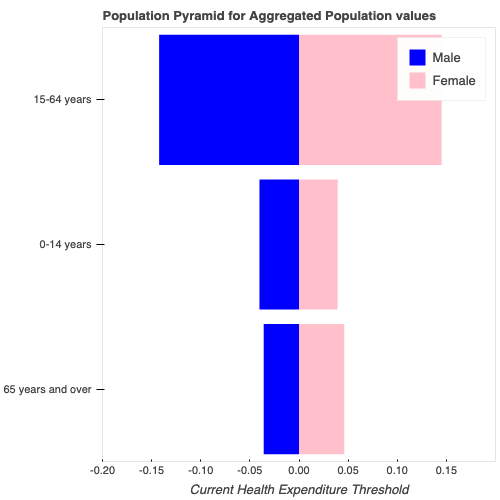

In [76]:
from IPython.display import Image 
Image('pyramid plot.png')